## Credits

This analysis is built upon the foundational work by [@carlmcbrideellis](https://www.kaggle.com/carlmcbrideellis) from the JS 2021 competition, who published the acclaimed notebook titled **"Jane Street: EDA of Day 0 and Feature Importance."** I want to extend my gratitude to Carl for his insightful contribution.

In this notebook, I have adapted and utilized Carl's original code to analyze this year's Jane Street competition data. I am employing the **Dask** library instead of the original **PyArrow** framework used by Carl. 

![](http://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTp5YjQGHIHm4i2W_5ES846YKjaLcNL78DJLw&s)

# Jane Street Market Prediction: A simple EDA

> "*Machine learning (ML) at Jane Street begins, unsurprisingly, with data. We collect and store around 2.3TB of market data every day. Hidden in those petabytes of data are the relationships and statistical regularities which inform the models inside our strategies. But it’s not just awesome models. ML work in a production environment like Jane Street’s involves many interconnected pieces.*" -- [Jane Street Tech Blog "*Real world machine learning*"](https://blog.janestreet.com/real-world-machine-learning-part-1/).

This notebook is a simple exploratory data analysis (EDA) of the files provided for the kaggle [Jane Street Market Prediction](https://www.kaggle.com/c/jane-street-market-prediction) competition. Here we shall...

> "**Explore the data:** *It’s hard to know what techniques to throw at a problem before we understand what the data looks like, and indeed figure out what data to use. Spending the time to visualize and understand the structure of the problem helps pick the right modeling tools for the job. Plus, pretty plots are catnip to traders and researchers!*"

## <center style="background-color:Gainsboro; width:40%;">Contents</center>
* [The train.csv file is big](#train_csv)
* [responders](#resp)
* [weight](#weight)
* [Cumulative return](#return)
* [Time](#time)
* [The `features.csv` file](#features_file)
* [The first day ("day 0")](#day_0)
* [Are there any missing values?](#missing_values)
* [Is there any missing data: Days 2 and 294](#missing_data)
* [Permutation Importance using the Random Forest](#permutation)
* [Is there any correlation between day 100 and day 200?](#Pearson)

In [1]:
# !pip install dask

In [2]:
# numpy
import numpy as np

# pandas stuff
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# plotting stuff
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
colorMap = sns.light_palette("blue", as_cmap=True)
#plt.rcParams.update({'font.size': 12})


# install dabl
#!pip install dabl > /dev/null
#import dabl
# install datatable
#!pip install datatable > /dev/null
#import datatable as dt

# misc
import missingno as msno

# system
import warnings
warnings.filterwarnings('ignore')
# for the image import
import os
from IPython.display import Image
# garbage collector to keep RAM in check
import gc  

In [3]:
%%time
import dask.dataframe as dd
train_data = dd.read_parquet('./train.parquet/train.parquet')
train_data.head()

CPU times: total: 14.4 s
Wall time: 1min 53s


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,0.242971,0.263400,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,NaN,-0.169586,NaN,-1.335938,-1.707803,0.910130,NaN,1.636431,1.522133,-1.551398,-0.229627,NaN,NaN,1.378301,-0.283712,0.123196,NaN,NaN,NaN,0.281180,0.269163,0.349028,-0.012596,-0.225932,NaN,-1.073602,NaN,NaN,-0.181716,NaN,NaN,NaN,0.564021,2.088506,0.832022,NaN,0.204797,NaN,NaN,-0.808103,NaN,-2.037683,0.727661,NaN,-0.989118,-0.345213,-1.36224,NaN,NaN,NaN,NaN,NaN,-1.251104,-0.110252,-0.491157,-1.022690,0.152241,-0.659864,NaN,NaN,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,NaN,0.317467,NaN,-1.250016,-1.682929,1.412757,NaN,0.520378,0.744132,-0.788658,0.641776,NaN,NaN,0.227200,0.580907,1.128879,NaN,NaN,NaN,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835207,-0.002704,-0.621836,NaN,1.172836,NaN,NaN,-1.625862,NaN,-1.410017,1.063013,NaN,0.888355,0.467994,-1.36224,NaN,NaN,NaN,NaN,NaN,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,NaN,NaN,-0.281207,-0.182894,-0.245565,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,0.187227,0.249901,-0.773050,11,7,76,-0.675719,-0.199404,-0.586798,NaN,-0.814909,NaN,-1.296782,-2.040234,0.639589,NaN,1.597359,0.657514,-1.350148,0.364215,NaN,NaN,-0.017751,-0.317361,-0.122379,NaN,NaN,NaN,-0.320921,-0.958090,-2.436589,0.070999,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420632,-3.515137,-4.677760,NaN,0.535897,NaN,NaN,-0.725420,NaN,-2.294170,1.764551,NaN,-0.120789,-0.063458,-1.36224,NaN,NaN,NaN,NaN,NaN,-0.882604,-0.072482,-0.617934,-0.863230,-0.241892,-0.709919,NaN,NaN,0.377131,0.300724,-0.106842,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,NaN,-0.251882,NaN,-1.902009,-0.979447,0.241165,NaN,-0.392359,-0.224699,-2.129397,-0.855287,NaN,NaN,0.404142,-0.578156,0.105702,NaN,NaN,NaN,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382074,2.669135,0.611711,NaN,2.413415,NaN,NaN,1.313203,NaN,-0.810125,2.939022,NaN,3.988801,1.834661,-1.36224,NaN,NaN,NaN,NaN,NaN,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,NaN,NaN,-0.226891,-0.251412,-0.215522,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,NaN,0.646086,NaN,-1.844685,-1.586560,-0.182024,NaN,-0.969949,-0.673813,-1.282132,-1.399894,NaN,NaN,0.043815,-0.320225,-0.031713,NaN,NaN,NaN,-0.088420,-0.995003,-2.635336,-0.196461,-0.618719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.014600,-2.321076,-3.711265,N

In [4]:
# Compute the number of rows
row_count = len(train_data)

print(f"Total number of rows: {row_count}")

Total number of rows: 47127338


We can see that it has a total of 4,71,27,338 rows.

I have used dask to load in the `train.parquet` and it took almost 5.31 sec.

In [15]:
# Count the unique 'date_id' values
unique_dates = train_data['date_id'].nunique().compute()

print(f"Number of unique days (date_id): {unique_dates}")

Number of unique days (date_id): 1699


<a class="anchor" id="return"></a>
## <center style="background-color:Gainsboro; width:40%;">resp</center>

There are a total of 1699 days of data in `train.parquet` (*i.e.* more than four and a half years of trading data). Let us take a look at the cumulative values of `responders` over time. 

> "*The longer the Time Horizon, the more aggressive, or riskier portfolio, an investor can build. The shorter the Time Horizon, the more conservative, or less risky, the investor may want to adopt.*"

The cumulative sums appear to be starting from a negative value (or a much lower cumulative sum), indicating that the total responses have been negative right from the beginning. This suggests that there may have been more negative trades or less positive performance overall.

4758

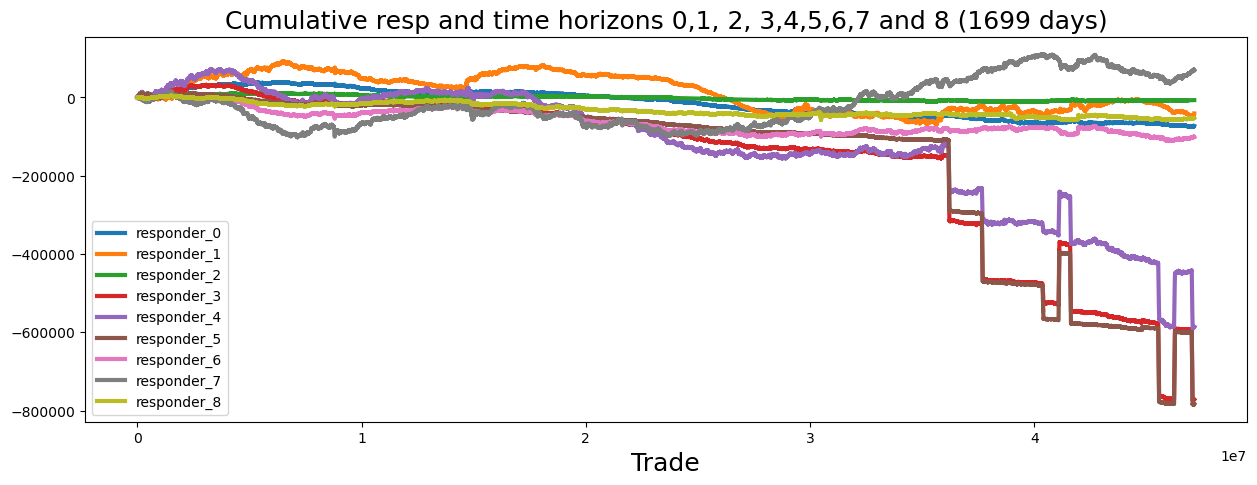

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
#balance= pd.Series(train_data['resp']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp and time horizons 0,1, 2, 3,4,5,6,7 and 8 (1699 days)", fontsize=18)
for i in range(0,9):
    resp_temp = pd.Series(train_data[f'responder_{i}']).cumsum()
    resp_temp.plot(lw=3,label = f'responder_{i}')
plt.legend(loc="lower left")
del resp_temp
gc.collect()

We can see that `responder_6` (in pink) most closely follows time horizon 8 (`responder_8` is the uppermost curve). 


Let us now plot a histogram of the `responder_6` values (here only shown for values between -5 and 5)

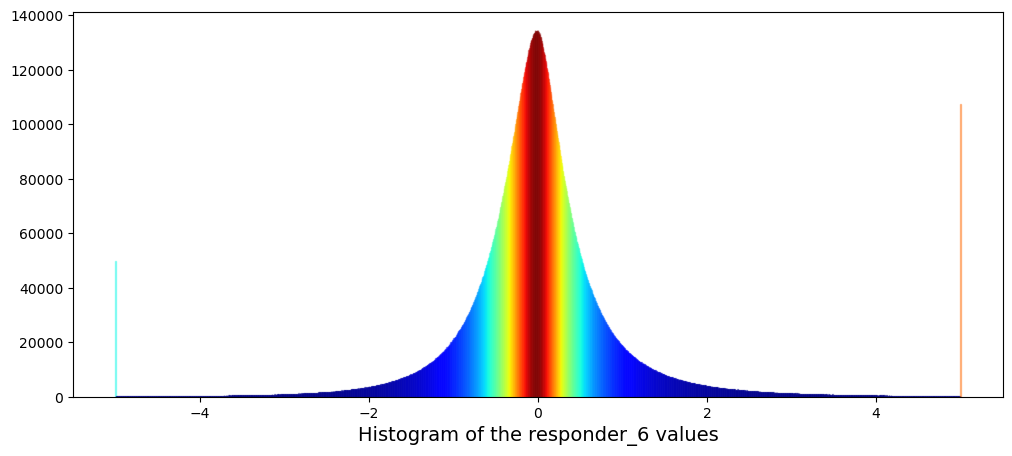

In [21]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['responder_6'], 
             bins=3000, 
            #  kde_kws={"clip":(-5,5)}, 
             hist_kws={"range":(-5,5)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the responder_6 values", size=14)
plt.show();
gc.collect();

In [22]:
# Assuming train_data is a Dask DataFrame
# Compute the min and max values for responder_6
min_resp = train_data['responder_6'].min().compute()
print('The minimum value for resp is: %.5f' % min_resp)

max_resp = train_data['responder_6'].max().compute()
print('The maximum value for resp is: %.5f' % max_resp)


The minimum value for resp is: -5.00000
The maximum value for resp is: 5.00000


Let us also calculate the [skew](https://en.wikipedia.org/wiki/Skewness) and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis) of this distribution:

In [23]:
# Compute and print the skewness and kurtosis of responder_6
skew_resp = train_data['responder_6'].skew().compute()
kurt_resp = train_data['responder_6'].kurtosis().compute()

print("Skew of resp is:      %.2f" % skew_resp)
print("Kurtosis of resp is: %.2f"  % kurt_resp)


Skew of resp is:      0.47
Kurtosis of resp is: 6.86


Finally, let us fit a [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution) to this data

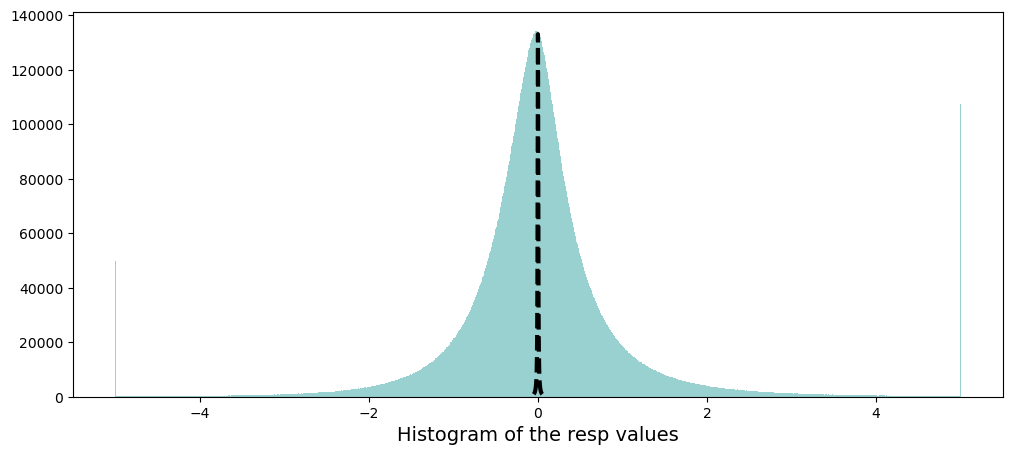

In [24]:
from scipy.optimize import curve_fit
# the values
x = list(range(len(values)))
x = [((i)-1500)/30000 for i in x]
y = values

def Lorentzian(x, x0, gamma, A):
    return A * gamma**2/(gamma**2+( x - x0 )**2)

# seed guess
initial_guess=(0, 0.001, 3000)

# the fit
parameters,covariance=curve_fit(Lorentzian,x,y,initial_guess)
sigma=np.sqrt(np.diag(covariance))

# and plot
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['responder_6'], 
             bins=3000, 
             kde_kws={"clip":(-5,5)}, 
             hist_kws={"range":(-5,5)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
#norm = plt.Normalize(values.min(), values.max())
#colors = plt.cm.jet(norm(values))
#for rec, col in zip(ax.patches, colors):
#    rec.set_color(col)
plt.xlabel("Histogram of the resp values", size=14)
plt.plot(x,Lorentzian(x,*parameters),'--',color='black',lw=3)
plt.show();
del values
gc.collect();

Note that a Cauchy distribution can be generated from the ratio of two independent normally distributed random variables with mean zero. The paper by [David E. Harris "*The Distribution of Returns*"](https://www.scirp.org/pdf/JMF_2017083015172459.pdf) goes into detail regarding the use of a Cauchy distribution to model returns.

<a class="anchor" id="weight"></a>
## <center style="background-color:Gainsboro; width:40%;">weight</center>

> *Each trade has an associated `weight` and `resp`, which together represents a return on the trade.*

In [28]:
# Calculate the number of zero weights
num_zero_weights = (train_data['weight'] == 0).sum().compute()  # Compute the total number of zero weights
total_weights = train_data.shape[0].compute()  # Compute the total number of rows

# Calculate the percentage of zero weights
percent_zeros = (100 * num_zero_weights) / total_weights

print('Percentage of zero weights is: %.2f%%' % percent_zeros)


Percentage of zero weights is: 0.00%


Let us see if there are any negative weights. A negative weight would be meaningless, but you never know...

In [29]:
min_weight = train_data['weight'].min().compute()
print('The minimum weight is: %.2f' % min_weight)

The minimum weight is: 0.15


And now to find the maximum weight used

In [30]:
max_weight = train_data['weight'].max().compute()
print('The maximum weight was: %.2f' % max_weight)

The maximum weight was: 10.24


Let us take a look at a histogram of the non-zero weights

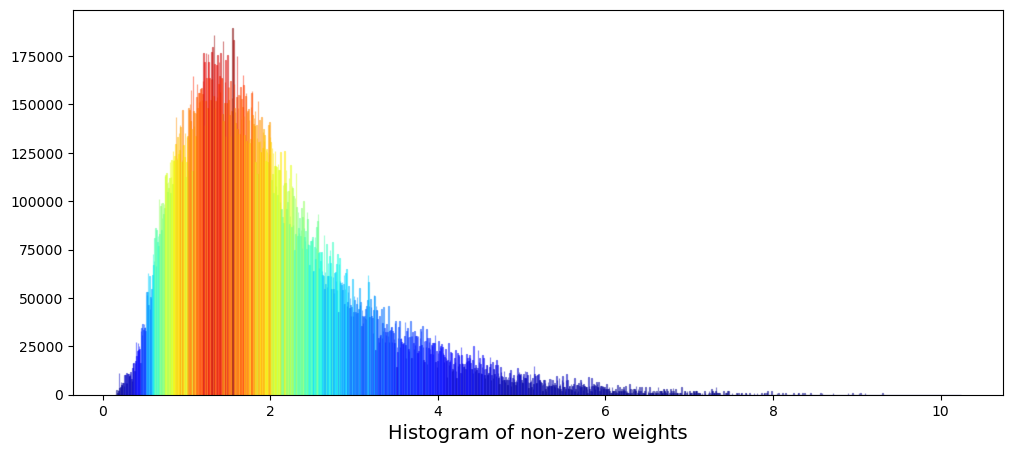

In [31]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['weight'], 
             bins=1400, 
             kde_kws={"clip":(0.15,10.24)}, 
             hist_kws={"range":(0.15,10.24)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of non-zero weights", size=14)
plt.show();
del values
gc.collect();

There appear to be one peak. Could this be indicative of a single underlying distribution that we see here. 
We can plot the logarithm of the weights (*Credit*: ["*Target Engineering; CV; ⚡ Multi-Target*"](https://www.kaggle.com/marketneutral/target-engineering-cv-multi-target) by [marketneutral](https://www.kaggle.com/marketneutral))

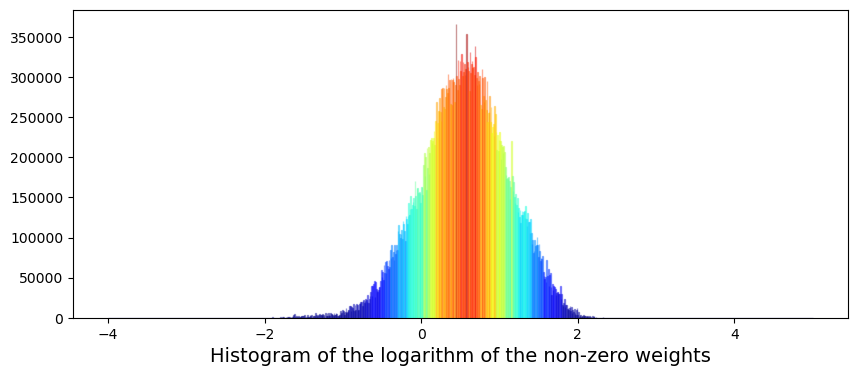

In [32]:
train_data_nonZero = train_data.query('weight > 0').reset_index(drop = True)
plt.figure(figsize = (10,4))
ax = sns.distplot(np.log(train_data_nonZero['weight']), 
             bins=1000, 
             kde_kws={"clip":(-4,5)}, 
             hist_kws={"range":(-4,5)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the logarithm of the non-zero weights", size=14)
plt.show();
gc.collect();

and we can now try to fit a pair of Gaussian functions to this distribution

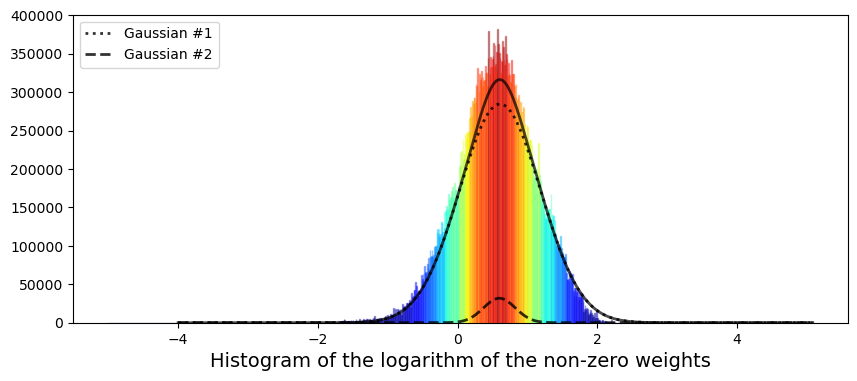

In [33]:
from scipy.optimize import curve_fit
# the values
x = list(range(len(values)))
x = [(i/110)-4 for i in x]
y = values

# define a Gaussian function
def Gaussian(x,mu,sigma,A):
    return A*np.exp(-0.5 * ((x-mu)/sigma)**2)

def bimodal(x,mu_1,sigma_1,A_1,mu_2,sigma_2,A_2):
    return Gaussian(x,mu_1,sigma_1,A_1) + Gaussian(x,mu_2,sigma_2,A_2)

# seed guess
initial_guess=(1, 1 , 1,    1, 1, 1)

# the fit
parameters,covariance=curve_fit(bimodal,x,y,initial_guess)
sigma=np.sqrt(np.diag(covariance))

# the plot
plt.figure(figsize = (10,4))
ax = sns.distplot(np.log(train_data_nonZero['weight']), 
             bins=1000, 
             kde_kws={"clip":(-5,5)}, 
             hist_kws={"range":(-5,5)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the logarithm of the non-zero weights", size=14)
# plot gaussian #1
plt.plot(x,Gaussian(x,parameters[0],parameters[1],parameters[2]),':',color='black',lw=2,label='Gaussian #1', alpha=0.8)
# plot gaussian #2
plt.plot(x,Gaussian(x,parameters[3],parameters[4],parameters[5]),'--',color='black',lw=2,label='Gaussian #2', alpha=0.8)
# plot the two gaussians together
plt.plot(x,bimodal(x,*parameters),color='black',lw=2, alpha=0.7)
plt.legend(loc="upper left");
plt.show();
del values
gc.collect();

<a class="anchor" id="return"></a>
## <center style="background-color:Gainsboro; width:40%;">Cumulative return</center>

Let us take a look at the cumulative daily return over time, which is given by `weight` multiplied by the value of `responders`

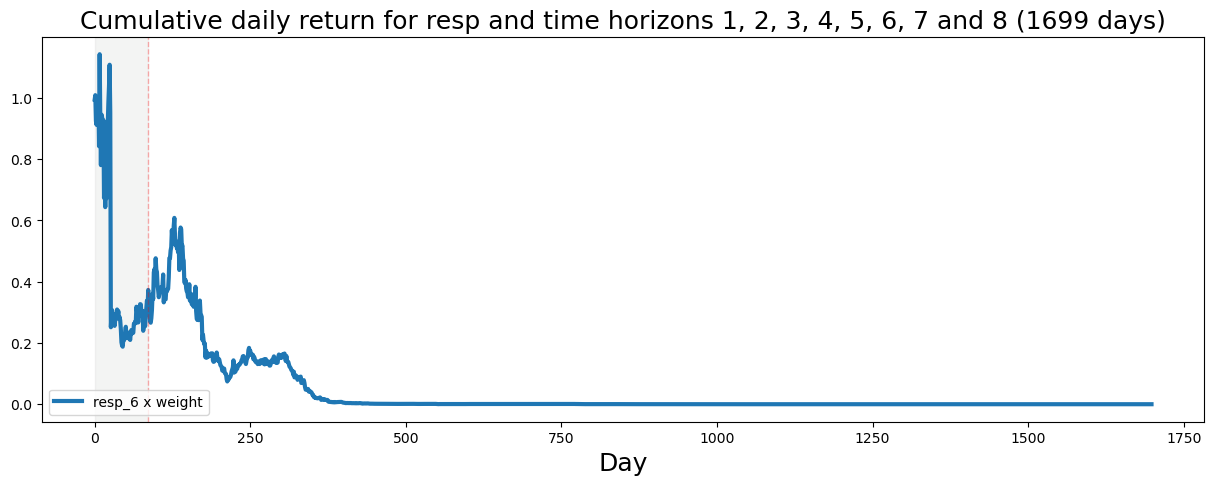

In [35]:
# train_data['weight_resp_1'] = train_data['weight']*train_data['responder_1']
# train_data['weight_resp_2'] = train_data['weight']*train_data['responder_2']
# train_data['weight_resp_3'] = train_data['weight']*train_data['responder_3']
# train_data['weight_resp_4'] = train_data['weight']*train_data['responder_4']
# train_data['weight_resp_5'] = train_data['weight']*train_data['responder_5']
train_data['weight_resp_6'] = train_data['weight']*train_data['responder_6']
# train_data['weight_resp_7'] = train_data['weight']*train_data['responder_7']
# train_data['weight_resp_8'] = train_data['weight']*train_data['responder_8']
fig, ax = plt.subplots(figsize=(15, 5))
# resp_1  = pd.Series(1+(train_data.groupby('date_id')['weight_resp_1'].mean())).cumprod()
# resp_2  = pd.Series(1+(train_data.groupby('date_id')['weight_resp_2'].mean())).cumprod()
# resp_3  = pd.Series(1+(train_data.groupby('date_id')['weight_resp_3'].mean())).cumprod()
# resp_4  = pd.Series(1+(train_data.groupby('date_id')['weight_resp_4'].mean())).cumprod()
# resp_5  = pd.Series(1+(train_data.groupby('date_id')['weight_resp_5'].mean())).cumprod()
resp_6  = pd.Series(1+(train_data.groupby('date_id')['weight_resp_6'].mean())).cumprod()
# resp_7  = pd.Series(1+(train_data.groupby('date_id')['weight_resp_7'].mean())).cumprod()
# resp_8  = pd.Series(1+(train_data.groupby('date_id')['weight_resp_8'].mean())).cumprod()
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Cumulative daily return for resp and time horizons 1, 2, 3, 4, 5, 6, 7 and 8 (1699 days)", fontsize=18)
#resp.plot(lw=3, label='resp x weight')
# resp_1.plot(lw=3, label='resp_1 x weight')
# resp_2.plot(lw=3, label='resp_2 x weight')
# resp_3.plot(lw=3, label='resp_3 x weight')
# resp_4.plot(lw=3, label='resp_4 x weight')
# resp_5.plot(lw=3, label='resp_5 x weight')
resp_6.plot(lw=3, label='resp_6 x weight')
# resp_7.plot(lw=3, label='resp_7 x weight')
# resp_8.plot(lw=3, label='resp_8 x weight')
# day 85 marker
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
plt.legend(loc="lower left");

We can see that `resp_5`, representing a more conservative strategy, result in the highest return.

We shall now plot a histogram of the `weight` multiplied by the value of `responder 6`

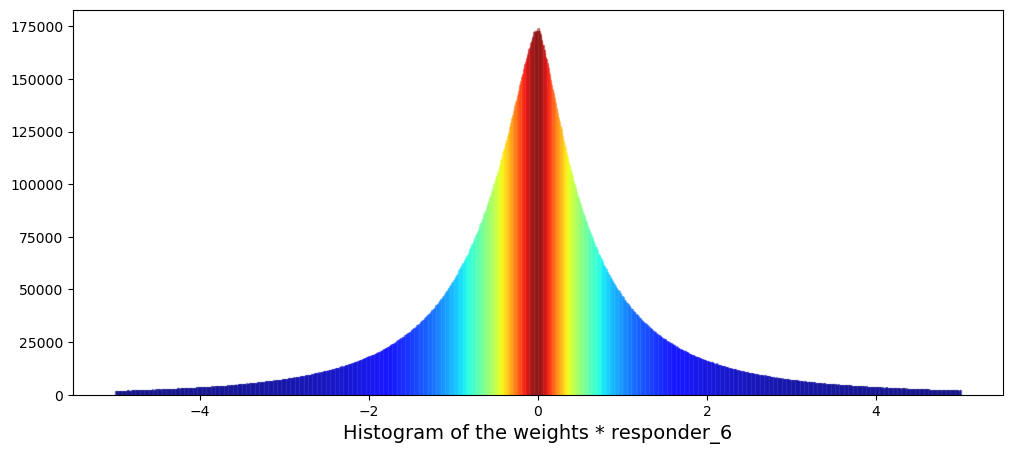

In [36]:
train_data_no_0 = train_data.query('weight > 0').reset_index(drop = True)
train_data_no_0['wAbsResp'] = train_data_no_0['weight'] * (train_data_no_0['responder_6'])
#plot
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data_no_0['wAbsResp'], 
             bins=1500, 
             kde_kws={"clip":(-5,5)}, 
             hist_kws={"range":(-5,5)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the weights * responder_6", size=14)
plt.show();

<a class="anchor" id="time"></a>
## <center style="background-color:Gainsboro; width:40%;">Time</center>
Let us plot the number of `time_id` per day.

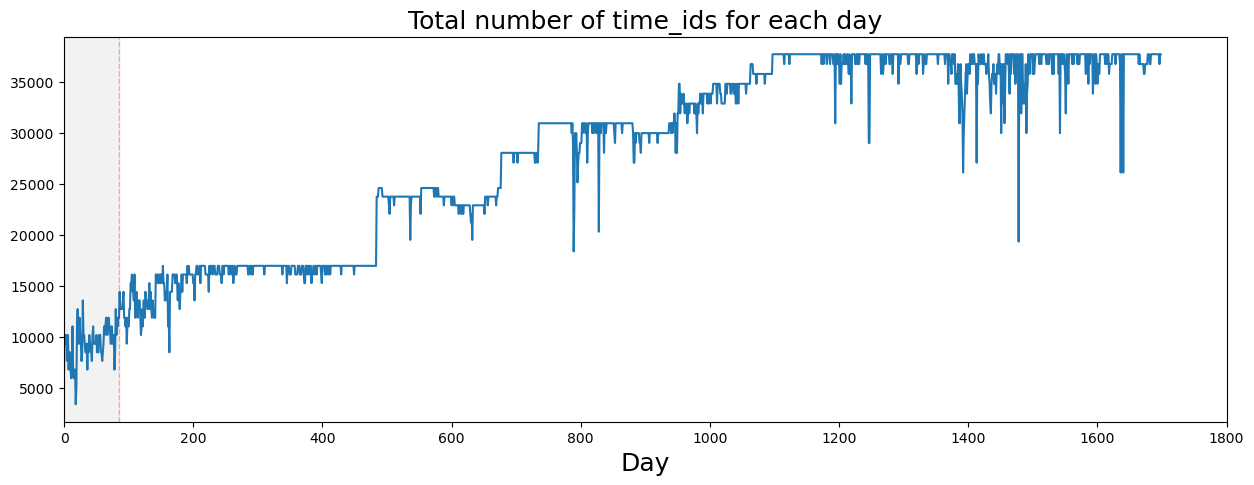

In [37]:
# Group by 'date_id' and count 'time_id'
trades_per_day = train_data.groupby(['date_id'])['time_id'].count().compute()  # Compute the result

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(trades_per_day.index, trades_per_day.values)  # Plot with x (day) and y (count)
ax.set_xlabel("Day", fontsize=18)
ax.set_title("Total number of time_ids for each day", fontsize=18)

# Add a vertical line and shaded region for day 85
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85, color='gray', alpha=0.1)  # Changed from sns.xkcd_rgb['grey'] to 'gray' for simplicity

# Set x-axis limits
ax.set_xlim(xmin=0, xmax=1800)

# Show the plot
plt.show()


If we assume a [trading day](https://en.wikipedia.org/wiki/Trading_day) is 6½ hours long (*i.e.* 23400 seconds) then

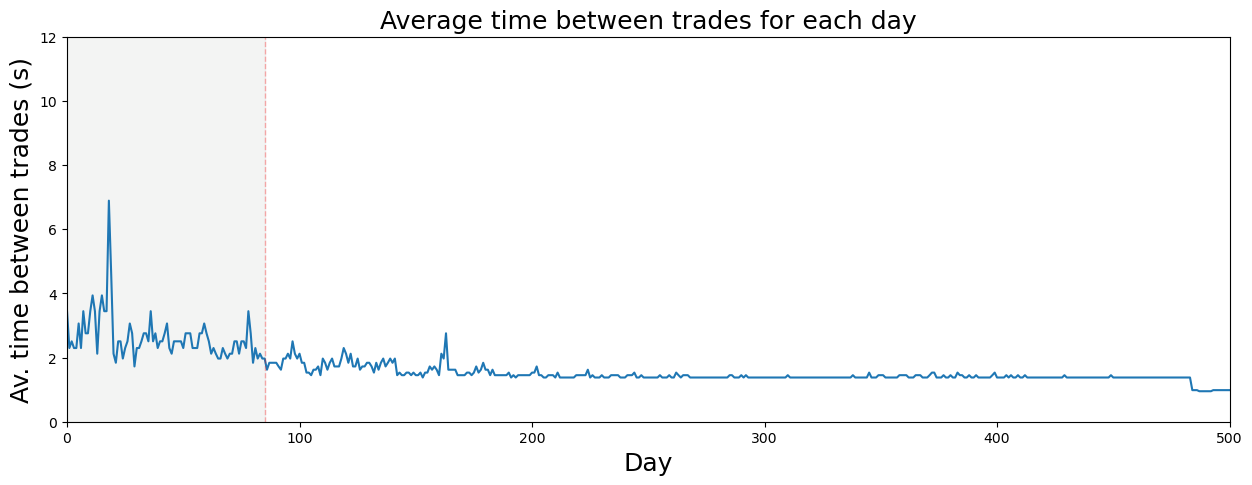

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(23400/trades_per_day)
ax.set_xlabel ("Day", fontsize=18)
ax.set_ylabel ("Av. time between trades (s)", fontsize=18)
ax.set_title ("Average time between trades for each day", fontsize=18)
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=500)
ax.set_ylim(ymin=0)
ax.set_ylim(ymax=12)
plt.show()


Here is a histogram of the number of trades per day (it has been [suggested](https://www.kaggle.com/c/jane-street-market-prediction/discussion/201930#1125847) that the number of trades per day is an indication of the [volatility](https://www.investopedia.com/terms/v/volatility.asp) that day)

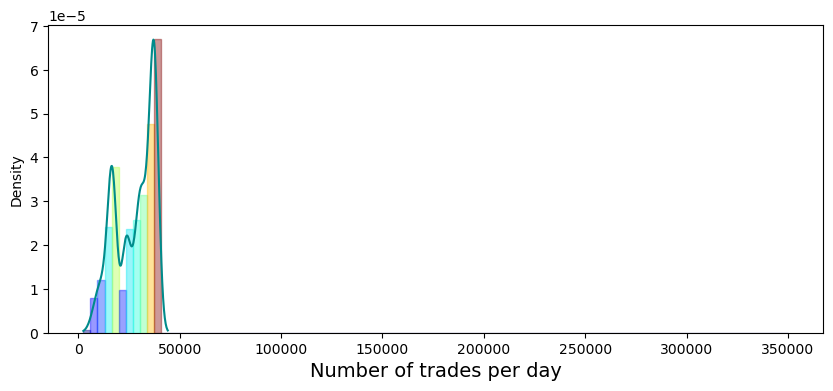

In [39]:
plt.figure(figsize = (10,4))
# the minimum has been set to 1000 so as not to draw the partial days like day 2 and day 294
# the maximum number of trades per day is 18884
# I have used 100 bins for the 1699 days
ax = sns.distplot(trades_per_day, 
             bins=100, 
             kde_kws={"clip":(2500,350000)}, 
             hist_kws={"range":(2500,350000)},
             color='darkcyan', 
             kde=True);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Number of trades per day", size=14)
plt.show();

If that is the case, then 'volatile' days, say with more than 9k trades (*i.e.* `time_id`) per day, are the following 

In [40]:
volatile_days = pd.DataFrame(trades_per_day[trades_per_day > 9000])
volatile_days.T

date_id,1,2,3,4,6,13,20,21,22,23,24,25,26,29,30,31,32,35,37,39,40,41,44,45,46,47,48,49,50,54,55,56,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038

<a class="anchor" id="features_file"></a>
## <center style="background-color:Gainsboro; width:40%;">The features.csv file</center>
​
We are also provided with a `features.csv` file which contains "*metadata pertaining to the anonymized features*". Let us take a quick look at it, where `1` is `True` and `0` is `False`. The file has 17 "tags" associated with each feature (00 - 78).

In [42]:
feature_tags = pd.read_csv("./features.csv" ,index_col=0)
# convert to binary
feature_tags = feature_tags*1
# plot a transposed dataframe
feature_tags.T.style.background_gradient(cmap='Oranges')

feature,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
tag_0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tag_1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tag_2,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tag_3,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tag_4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
tag_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tag_6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tag_7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
tag_8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
tag_9,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0


Just for fun let us re-plot the above data, but now in '8-bit' mode; totally illegible, but may perhaps serve as an overall visual aid...

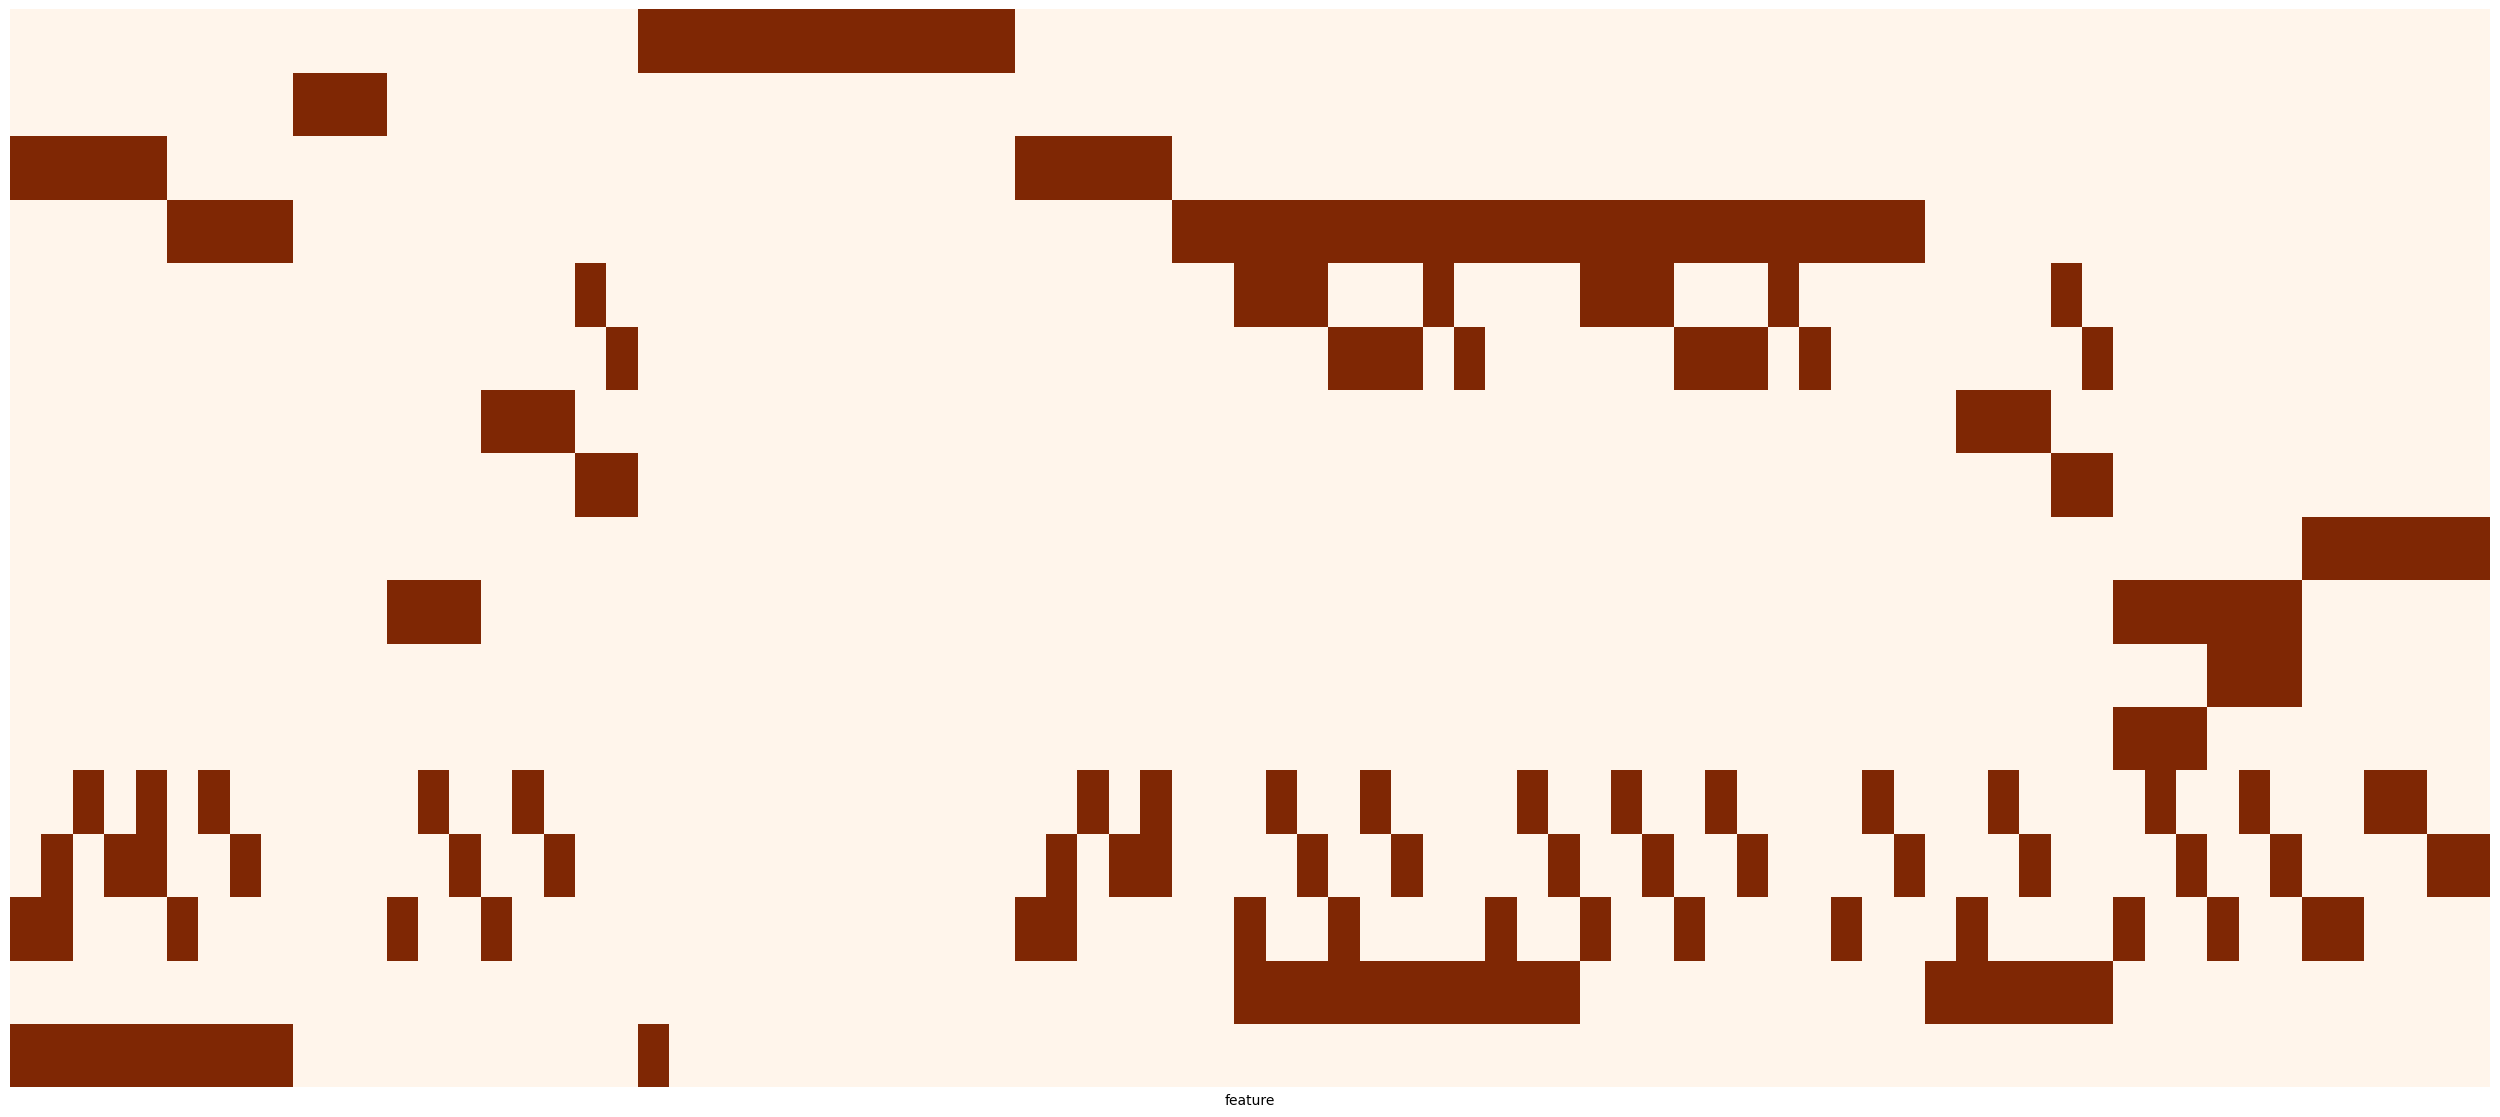

In [43]:
plt.figure(figsize=(32,14))
sns.heatmap(feature_tags.T,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            cmap="Oranges");

Let us sum the number of tags for each feature:

In [44]:
tag_sum = pd.DataFrame(feature_tags.T.sum(axis=0),columns=['Number of tags'])
tag_sum.T

feature,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
Number of tags,3,4,3,3,4,3,3,3,2,1,1,1,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,2,3,2,2,3,1,1,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,1,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2


We can see that all of the features have at least one tag, and some as many as four. 

<a class="anchor" id="day_0"></a>
## <center style="background-color:Gainsboro; width:90%;">Now let us take a look at the first day ("day 0")</center>
To do this we shall make a new dataframe called `day_0`

In [7]:
day_0 = train_data.loc[train_data['date_id'] == 0]

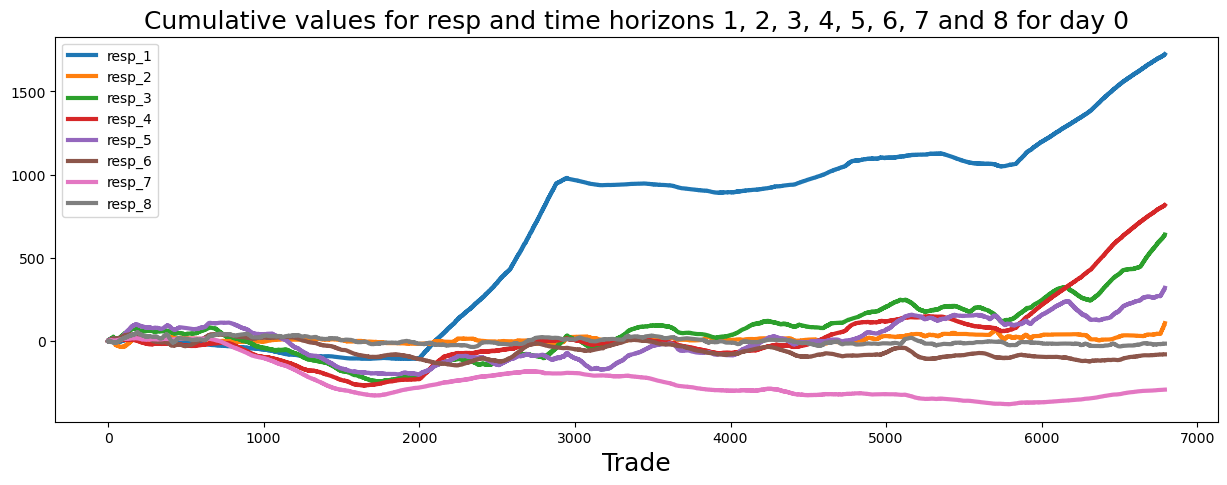

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))
resp_1= pd.Series(day_0['responder_1']).cumsum()
resp_2= pd.Series(day_0['responder_2']).cumsum()
resp_3= pd.Series(day_0['responder_3']).cumsum()
resp_4= pd.Series(day_0['responder_4']).cumsum()
resp_5= pd.Series(day_0['responder_5']).cumsum()
resp_6= pd.Series(day_0['responder_6']).cumsum()
resp_7= pd.Series(day_0['responder_7']).cumsum()
resp_8= pd.Series(day_0['responder_8']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative values for resp and time horizons 1, 2, 3, 4, 5, 6, 7 and 8 for day 0", fontsize=18)
resp_1.plot(lw=3, label = 'resp_1')
resp_2.plot(lw=3, label = 'resp_2')
resp_3.plot(lw=3, label = 'resp_3')
resp_4.plot(lw=3, label = 'resp_4')
resp_5.plot(lw=3, label = 'resp_5')
resp_6.plot(lw=3, label = 'resp_6')
resp_7.plot(lw=3, label = 'resp_7')
resp_8.plot(lw=3, label = 'resp_8')
plt.legend(loc="upper left");

In [47]:
del resp_1
del resp_2
del resp_3
del resp_4
del resp_5
del resp_6
del resp_7
del resp_8
gc.collect();

### <center style="background-color:Gainsboro; width:80%;">Descriptive statistics of the `train.csv` file for day 0</center>
Some simple [descriptive statistics](https://en.wikipedia.org/wiki/Descriptive_statistics) of the day 0 data:

In [48]:
# Convert Dask DataFrame to Pandas
day_0_pandas = day_0.describe().compute()

# Apply background gradient styling (Pandas operation)
styled_day_0 = day_0_pandas.style.background_gradient(cmap=colorMap)

# Display the styled DataFrame
styled_day_0


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,weight_resp_1,weight_resp_2,weight_resp_3,weight_resp_4,weight_resp_5,weight_resp_6,weight_resp_7,weight_resp_8
count,6792.000000,6792.000000,6792.000000,6792.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6600.000000,6792.000000,6760.000000,6792.000000,6792.000000,6792.000000,0.000000,6792.000000,6792.000000,6792.000000,6792.000000,0.000000,0.000000,6792.000000,6792.000000,6792.000000,0.000000,6720.000000,6720.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,4567.000000,5411.000000,5269.000000,4567.000000,5411.000000,5269.000000,4979.000000,4979.000000,6792.000000,6792.000000,6792.000000,5768.000000,6784.000000,6568.000000,5768.000000,6784.000000,6568.000000,6792.000000,6792.000000,6720.000000,6792.000000,6792.000000,6792.000000,4317.000000,4437.000000,4417.000000,4979.000000,4979.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6720.000000,6720.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000
mean,0.000000,424.000000,13.625000,1.739316,nan,nan,nan,nan,nan,0.063157,-0.005944,0.011566,-0.834207,18.125000,5.750000,69.625000,-0.457174,-0.206238,-0.334927,0.449872,0.318257,0.447428,-0.375769,0.137104,0.569384,nan,0.559380,0.607398,-1.295865,-0.217157,nan,nan,0.154185,-0.050409,0.408964,nan,0.194522,0.258828,0.142411,0.155841,0.071012,-0.201318,-0.504054,-0.425676,0.201620,-0.041113,0.772335,0.332331,0.559492,-0.861139,0.607587,0.055309,0.000049,0.064669,-0.268370,-0.220266,-0.121650,0.185384,0.059935,0.052475,-0.155835,0.376548,0.000833,0.012712,0.030884,-1.362240,0.212048,0.246729,0.225783,0.350334,0.192734,-0.420930,-0.165892,-0.291967,-0.457444,-0.179739,-0.321785,-0.149823,-0.118753,-0.119273,-0.095349,-0.128001,-0.099621,0.067315,0.253773,0.015864,0.094224,0.120296,0.047118,-0.011707,-0.042917,-0.002250,0.414297,0.032377,0.225770,0.322637,0.100689,-0.005526,0.011935,0.005434
std,0.000000,245.103058,8.999794,1.045776,nan,nan,nan,nan,nan,0.530720,0.590658,0.569501,0.231302,14.547871,1.714040,40.276833,0.356841,0.617339,0.437760,0.579614,0.896588,0.637791,0.843538,0.934061,0.469623,nan,0.845094,0.686837,0.444553,0.799586,nan,nan,0.569707,0.360060,0.462339,nan,0.566419,1.174328,0.494722,0.485736,1.150642,0.419304,0.522832,1.426284,1.547537,1.519567,1.363718,1.530473,1.458899,0.931827,0.939735,1.303136,5.414213,1.652377,0.828941,1.291623,1.006671,0.887992,1.287284,1.039272,0.681252,0.653684,0.422064,0.633948,0.565765,0.000000,0.629092,0.833719,0.789117,1.110667,0.839826,0.326161,0.632147,0.436438,0.476147,0.768722,0.580165,0.517101,0.522241,0.711095,0.696325,0.592929,0.608001,0.884881,0.948112,0.728587,1.123619,0.865900,1.173627,0.529894,0.471536,0.590221,1.55492

<a class="anchor" id="missing_values"></a>
## <center style="background-color:Gainsboro; width:60%;">Are there any missing values?</center>

To start with let us look at day 0 

In [ ]:
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[49], line 5
      2 day_0_pandas = day_0.compute()
      4 # Visualize missing data using missingno matrix
----> 5 msno.matrix(day_0_pandas, color=(0.35, 0.35, 0.75))

File c:\Users\admin\anaconda3\envs\kaggle_cl\lib\site-packages\missingno\missingno.py:72, in matrix(df, filter, n, p, sort, figsize, width_ratios, color, fontsize, labels, sparkline, inline, freq, ax)
     70 # Remove extraneous default visual elements.
     71 ax0.set_aspect('auto')
---> 72 ax0.grid(b=False)
     73 ax0.xaxis.tick_top()
     74 ax0.xaxis.set_ticks_position('none')

File c:\Users\admin\anaconda3\envs\kaggle_cl\lib\site-packages\matplotlib\axes\_base.py:3194, in _AxesBase.grid(self, visible, which, axis, **kwargs)
   3192 _api.check_in_list(['x', 'y', 'both'], axis=axis)
   3193 if axis in ['x', 'both']:
-> 3194     self.xaxis.grid(visible, which=which, **kwargs)
   3195 if axis in ['y', 'both']:
   3196     self.yaxis.grid(visible, which=which, **kwargs)

File c:\Users\admin\anaconda3\envs\kaggle_cl\lib\site-packages\matplotlib\axis.py:1660, in Axis.grid(self, visible, which, **kwargs)
   1657 if which in ['major', 'both']:
   1658     gridkw['gridOn'] = (not self._major_tick_kw['gridOn']
   1659                         if visible is None else visible)
-> 1660     self.set_tick_params(which='major', **gridkw)
   1661 self.stale = True

File c:\Users\admin\anaconda3\envs\kaggle_cl\lib\site-packages\matplotlib\axis.py:932, in Axis.set_tick_params(self, which, reset, **kwargs)
    919 """
    920 Set appearance parameters for ticks, ticklabels, and gridlines.
    921 
   (...)
    929     gridlines.
    930 """
    931 _api.check_in_list(['major', 'minor', 'both'], which=which)
--> 932 kwtrans = self._translate_tick_params(kwargs)
    934 # the kwargs are stored in self._major/minor_tick_kw so that any
    935 # future new ticks will automatically get them
    936 if reset:

File c:\Users\admin\anaconda3\envs\kaggle_cl\lib\site-packages\matplotlib\axis.py:1076, in Axis._translate_tick_params(kw, reverse)
   1074 for key in kw_:
   1075     if key not in allowed_keys:
-> 1076         raise ValueError(
   1077             "keyword %s is not recognized; valid keywords are %s"
   1078             % (key, allowed_keys))
   1079 kwtrans.update(kw_)
   1080 return kwtrans

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

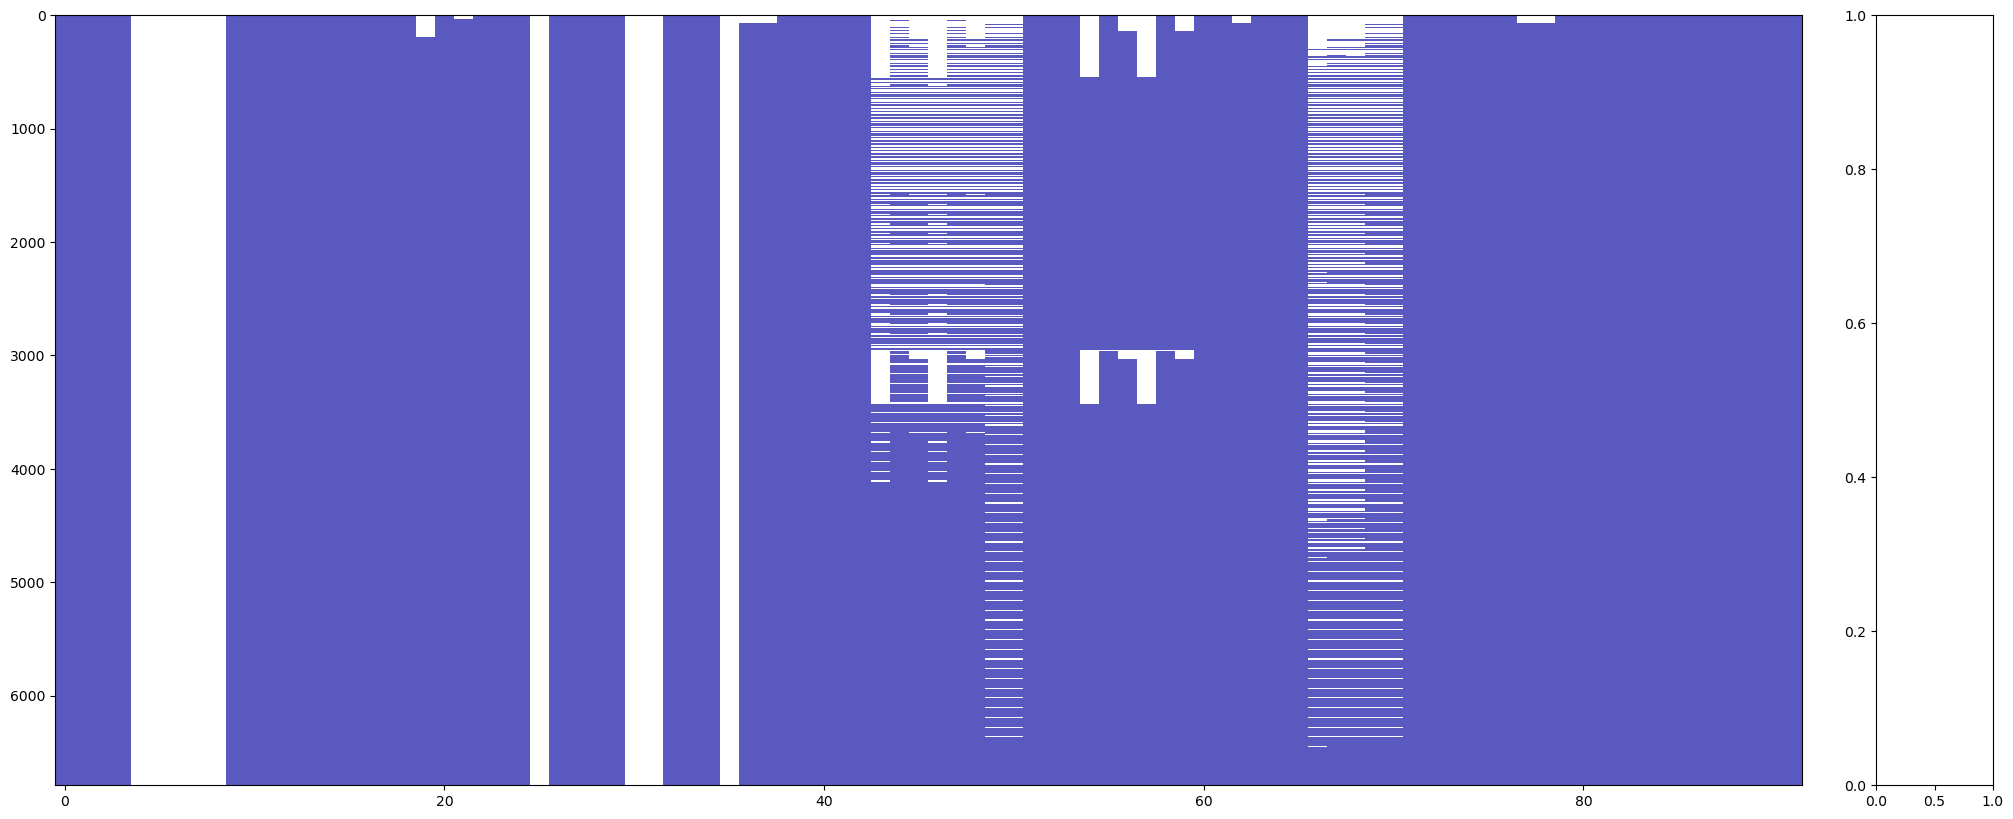

In [8]:
# Convert Dask DataFrame to Pandas
day_0_pandas = day_0.compute()

# Visualize missing data using missingno matrix
msno.matrix(day_0_pandas, color=(0.35, 0.35, 0.75))

graphically we can see that indeed there are complete chunks of missing data (in white) in some of the columns, and there appears to be numerous columns like this.

Now let us look at the sum of the number of missing data in each column for the whole `train.csv` file:

In [50]:
#missing_data = pd.DataFrame(train_data.isna().sum().sort_values(ascending=False),columns=['Total missing'])
#missing_data.T

gone = train_data.isnull().sum().compute()
px.bar(gone, color=gone.values, title="Total number of missing values for each column").show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Overall Observations on Missing Values

1. **Repeated Missing Patterns**: Several features exhibit identical missing value counts. For instance:
   1. Features 00, 01, 02, 03, and 04 share the same number of missing values (3.18M).
   2. Features 21, 26, 27, and 31 also have identical missing values (8.43M).

2. **Pairs of Features with Similar Missing Values**: Some features tend to appear in pairs with the same number of missing values, such as: Features 39 and 42 (4.3M), 40 and 43 (67.85k), and 41 and 44 (1.09M).
   
3. **Other Groupings of Identical Missing Counts**: Features 50 and 53 (4.25M), 52 and 55 (1.04M), 65 and 66 (317.16k), 73 and 74 (483.76k), and 75 and 76 (58.43k) show identical missing value counts.

4. **Possible Data Collection Issues**: These repeated patterns may suggest that certain groups of features were collected together, or that specific sensors, processes, or systems responsible for generating these features faced common disruptions or failures.


| Features          | Missing Values      |
|-------------------|---------------------|
| 00, 01, 02, 03, 04 | 3.182052 M          |
| 21, 26, 27, 31     | 8.43 M              |
| 39, 42             | 4.3 M               |
| 40, 43             | 67.856 K            |
| 41, 44             | 1.093012 M          |
| 50, 53             | 4.25 M              |
| 52, 55             | 1.04 M              |
| 65, 66             | 317.163 K           |
| 73, 74             | 483.759 K           |
| 75, 76             | 58.43 K             |


There are more features with even less missing values. I think the interesting thing is not so much the quantity of missing values in so much as it may tell us which features represent similar measures/metrics.

Is day 0 special, or does every day have missing data?

In [ ]:
missing_features = train_data.iloc[:, 7:137].isnull().sum(axis=1).groupby(train_data['date_id']).sum().compute().to_frame()

# Now plot
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(missing_features)
ax.set_xlabel("Day", fontsize=18)
ax.set_title("Total number of missing values in all features for each day", fontsize=18)
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=2)
ax.axvspan(0, 85, color=sns.xkcd_rgb['grey'], alpha=0.1)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=1699)
plt.show()


Indeed we can see that there is missing data *almost* every day. We can see 5 linear line converging there indicating a pattern. 

In the notebook ["*Jane Street EDA Market Regime*"](https://www.kaggle.com/marketneutral/jane-street-eda-market-regime) written by [marketneutral](https://www.kaggle.com/marketneutral) a plot is made of the number of trades per day, and is strikingly similar to the above plot. In view of this, for curiosity, we shall plot the number of missing values in the features with respect to the number of trades, for each day.

In [ ]:
# Calculate the count of weights per date_id and flatten the column index
count_weights = train_data[['date_id', 'weight']].groupby('date_id').agg(['count']).compute()
count_weights.columns = ['weights']  # Flatten the column names

# Compute the missing features DataFrame
missing_features = train_data.iloc[:, 7:137].isnull().sum(axis=1).groupby(train_data['date_id']).sum().compute().to_frame()
missing_features.columns = ['missing']  # Rename the column for clarity

# Merge the DataFrames
result = pd.merge(count_weights, missing_features, on="date_id", how="inner")

# Calculate the ratio and the mean of missing features per trade
result['ratio'] = result['missing'] / result['weights']
missing_per_trade = result['ratio'].mean()

# Now make a plot
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(result['ratio'])
plt.axhline(missing_per_trade, linestyle='--', alpha=0.85, c='r')
ax.set_xlabel("Day", fontsize=18)
ax.set_title("Average number of missing feature values per trade, for each day", fontsize=18)
plt.show()


We can see that the average comes out to be $\approx$ 2 missing feature values per trade, per day, but the plot suggests different patterns. The number of missing values decrease after 500 days and majority of missing values are prior to 500th day. Prior to day 250, the number of missing values exceed 8 on an average. 
This raises the question of [what to do with missing data in the unseen test data?](https://www.kaggle.com/c/jane-street-market-prediction/discussion/200691). Whatever one decides to do, in this competition time is of the essence, so we have to do it fast, and [Yirun Zhang](https://www.kaggle.com/gogo827jz) has made an exhaustive study of the time taken in various filling methods in the notebook ["*Optimise Speed of Filling-NaN Function*"](https://www.kaggle.com/gogo827jz/optimise-speed-of-filling-nan-function).

<a class="anchor" id="missing_data"></a>
## <center style="background-color:Gainsboro; width:80%;">Is there any missing data: Days 2 and 294</center>
If we produce scatter plots of `feature_64` we see that each day has the same sweeping pattern. Here is a plot of day 1 (in blue), day 2 (in red) and day 3 (blue again). Day 2 has been encircled as a visual aid.

In [ ]:
# Convert Dask DataFrames to Pandas DataFrames
day_1 = train_data.loc[train_data['date_id'] == 1].compute()
day_2 = train_data.loc[train_data['date_id'] == 2].compute()
day_3 = train_data.loc[train_data['date_id'] == 3].compute()

# Concatenate the Pandas DataFrames
three_days = pd.concat([day_1, day_2, day_3])

# Create the scatter plot
fig, ax = plt.subplots(figsize=(15, 3))
ax.scatter(three_days.time_id, three_days.feature_65, s=0.5, color='b', label='Days 1, 2, 3')
ax.scatter(day_2.time_id, day_2.feature_65, s=0.5, color='r', label='Day 2')
ax.scatter(1515, 5.2, s=1800, facecolors='none', edgecolors='black', linestyle='--', lw=2)
ax.set_xlabel('time_id')
ax.set_ylabel('feature_65')
ax.set_title('feature_65 for days 1, 2, and 3')
ax.legend()
plt.show()


### Plot of `responder_6` values with respect to time (`time_id`) for day 0

In [ ]:
# Convert Dask DataFrame to Pandas DataFrame
day_0 = day_0.compute()

# Now create the scatter plot
fig_1 = px.scatter(day_0, x='time_id', y='responder_6', 
                   trendline="ols", marginal_y="violin",
                   title="Scatter plot of resp with respect to ts_id for day 0")
fig_1.show()


<a class="anchor" id="permutation"></a>
## <center style="background-color:Gainsboro; width:100%;">Very quick Permutation Importance using the Random Forest</center>
We shall now perform a simple [permutation importance](https://www.kaggle.com/dansbecker/permutation-importance) calculation, a basic way of seeing which features may be important. We shall perform a regression, with `responder_6` as the target.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Assuming day_0 is already defined
# Select only the columns that contain 'feature'
X_train = day_0.loc[:, day_0.columns.str.contains('feature')]

# Step 1: Remove columns that are entirely NaN
X_train.dropna(axis=1, how='all', inplace=True)

# Step 2: Replace infinite values with NaN
X_train.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

# Fill remaining NaN values with the mean of each column
X_train.fillna(X_train.mean(), inplace=True)

# Ensure our target variable is correctly defined
y_train = day_0['responder_6']

# Step 3: Check if y_train has any missing values
if y_train.isnull().any():
    print("Target variable y_train contains NaN values. Please handle them before fitting the model.")
else:
    # Create and fit the RandomForestRegressor model
    regressor = RandomForestRegressor(max_features='auto')
    
    # Fit the model
    try:
        regressor.fit(X_train, y_train)
        print("Model trained successfully.")
    except ValueError as e:
        print(f"Error occurred while fitting the model: {e}")


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
perm_import = PermutationImportance(regressor, random_state=1).fit(X_train, y_train)
# visualize the results
eli5.show_weights(perm_import, top=15, feature_names = X_train.columns.tolist())

We can see in this very simple example that for the first day (**day 0**) the top 5 most important features appear to be 58, 05, 37, 07 and 49.

Note:

> Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. (Source: [scikit-learn permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html)).

It goes without saying that a serious study of the feature importance is essential (and will use *a lot* of CPU). For a much more advanced approach may I suggest taking a look at ["*Feature selection using the Boruta-SHAP package*"](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-the-boruta-shap-package). 

However, the global feature importance ranking does not tell the whole story, and in the notebook ["*TabNet and interpretability: Jane Street example*"](https://www.kaggle.com/carlmcbrideellis/tabnet-and-interpretability-jane-street-example) thanks to [TabNet](https://www.kaggle.com/carlmcbrideellis/jane-street-tabnet-3-0-0-starter-notebook) one can inspect which features were important for each and every calculation, and one can see that the process is much more dynamic than a static overall ranking would suggest.

<a class="anchor" id="Pearson"></a>
## <center style="background-color:Gainsboro; width:90%;">Is there any correlation between day 100 and day 200?</center>
Are the days independent? For the moment let us take a look at day(100) and day(200) using a [Pearson pairwise correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) matrix (this is a **big** matrix!). Why days 100 and 200? Because they are far apart in time, thus reducing any temporal leakage.
We shall use a [diverging colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) where red indicates positive linear correlation, and blue indicates linear anti-correlation:

In [ ]:
import pandas as pd

# Assuming day_100 and day_200 are already defined
day_100 = train_data.loc[train_data['date_id'] == 100].compute()
day_200 = train_data.loc[train_data['date_id'] == 200].compute()

# Concatenate the two DataFrames
day_100_and_200 = pd.concat([day_100, day_200])

# Calculate the correlation matrix
correlation_matrix = day_100_and_200.corr(method='pearson')

# Use the Styler to apply formatting and background gradient
styled_corr = correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}")

# Display the styled correlation matrix
styled_corr


It can be seen, these features have nan values and needs to be handled properly: 
1. feature_00
2. feature_01
3. feature_02
4. feature_03
5. feature_04
6. feature_21
7. feature_26
8. feature_27
9. feature_31

### <center style="background-color:LightGreen; width:40%;">Thank you for your time.</center>

Postscript:

> "*If you have been asked to develop ML strategies on your own, the odds are stacked
against you. It takes almost as much effort to produce one true investment strategy
as to produce a hundred, and the complexities are overwhelming*". ([Marcos Lopez de Prado in "*Advances in Financial Machine Learning*"](https://www.wiley.com/en-es/Advances+in+Financial+Machine+Learning-p-9781119482109))

> "*...It looks just a little more mathematical and regular than it is; its exactitude is obvious, but its inexactitude is hidden; its wildness lies in wait.*" (G. K. Chesterton (1908))

### <center style="background-color:LightGreen; width:40%;">Good luck to everyone!</center>
